使用transformer解决法语=>英语的翻译任务

transformer的核心：self-attentions

transformer **优点**：
- 无需对跨数据的时间/空间域的关系作出假设
- 并行计算
- distant item 互相影响彼此的输出
- 可以学习到长距离依赖关系

transformer **缺点**：
- 对于每一个step的xt的输出，是由整个历史信息计算得出，而不再是当前输入和hidden，这可能效率较低
- 如果输入具有时间/空间域的关系，则需要加入位置编码，否则整个model也只能看作是一个词袋模型

目录
* [1.加载数据 建立input pipeline](#)
* [2.位置编码 positional encoding](#)
* [3.掩码 masking](#3)
* [4.scaled dot product attention](#)
* [5.multi-head attention](#)
* [6.point wise feed forward network](#)
* [7.encoder layer](#)
* [8.decoder layer](#)
* [9.encoder](#)
* [10.decoder](#)
* [11.搭建transformer](#)
* [12.设置超参](#)
* [13.优化器](#)
* [14.损失和评价准则](#)
* [15.生成mask](#)
* [16.训练和保存](#)
* [17.评估](#)
* [18.attention的可视化](#)
* [19.总结](#)


## 1.加载数据 建立input pipeline

In [10]:
import torch
import torchtext

from sklearn.model_selection import train_test_split

import random
import re
from tqdm import tqdm  # 进度条
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import unicodedata
import datetime
import time
import copy

import os
print(os.getcwd()) # /home/xijian

ngpu = 4

use_cuda = torch.cuda.is_available()  ##检测是否有可用的gpu
device = torch.device("cuda:0" if (use_cuda and ngpu > 0) else "cpu")
print('device=', device)

project_dir = '/home/xijian/pycharm_projects/Magic-NLPer/'
# 当前目录cwd
cwd = project_dir + 'NLP/MachineTranslation/transformer/pytorch/'
data_dir = cwd + './data/' # 数据所在目录

/home/xijian
device= cuda:0


In [11]:
data_df = pd.read_csv(data_dir + 'eng-fra.txt',  # 数据格式：英语\t法语，注意我们的任务源语言是法语，目标语言是英语
                      encoding='UTF-8', sep='\t', header=None,
                      names=['eng', 'fra'], index_col=False)

print(data_df.shape)
print(data_df.values.shape)
print(data_df.values[0])
print(data_df.values[0].shape)
data_df.head()

(135842, 2)
(135842, 2)
['Go.' 'Va !']
(2,)


,eng,fra
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [4]:
# 数据预处理

# 将unicode字符串转化为ASCII码：
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


# 规范化字符串
def normalizeString(s):
    # print(s) # list  ['Go.']
    # s = s[0]
    s = s.lower().strip()
    s = unicodeToAscii(s)
    s = re.sub(r"([.!?])", r" \1", s)  # \1表示group(1)即第一个匹配到的 即匹配到'.'或者'!'或者'?'后，一律替换成'空格.'或者'空格!'或者'空格？'
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # 非字母以及非.!?的其他任何字符 一律被替换成空格
    s = re.sub(r'[\s]+', " ", s)  # 将出现的多个空格，都使用一个空格代替。例如：w='abc  1   23  1' 处理后：w='abc 1 23 1'
    return s


print(normalizeString('Va !'))
print(normalizeString('Go.'))

va !
go .


In [5]:
MAX_LENGTH = 10

eng_prefixes = (  # 之前normalizeString()已经对撇号等进行了过滤，以及清洗，小写化等
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# print(eng_prefixes)
pairs = [[normalizeString(s) for s in line] for line in data_df.values]

print('pairs num=', len(pairs))
print(pairs[0])
print(pairs[1])

pairs num= 135842
['go .', 'va !']
['run !', 'cours !']


In [6]:
# 文件是英译法，我们实现的是法译英，所以进行了reverse，所以pair[1]是英语
# 为了快速训练，仅保留“我是”“你是”“他是”等简单句子，并且删除原始文本长度大于10个标记的样本
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
           p[0].startswith(eng_prefixes)  # startswith first arg must be str or a tuple of str


def filterPairs(pairs):
    # 过滤，并交换句子顺序，得到法英句子对（之前是英法句子对）
    return [[pair[1], pair[0]] for pair in pairs if filterPair(pair)]


pairs = filterPairs(pairs)

print('after trimming, pairs num=', len(pairs))
print(pairs[0])
print(pairs[1])
print(random.choice(pairs))


after trimming, pairs num= 10599
['j ai ans .', 'i m .']
['je vais bien .', 'i m ok .']
['je suis si heureuse pour toi tom .', 'i m so happy for you tom .']


In [7]:
# 划分数据集：训练集和验证集
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=1234)

print(len(train_pairs))
print(len(val_pairs))

8479
2120


In [8]:
tokenizer = lambda x: x.split() # 分词器

SRC_TEXT = torchtext.data.Field(sequential=True,
                                tokenize=tokenizer,
                                # lower=True,
                                fix_length=MAX_LENGTH + 2,
                                preprocessing=lambda x: ['<start>'] + x + ['<end>'],
                                # after tokenizing but before numericalizing
                                # postprocessing # after numericalizing but before the numbers are turned into a Tensor
                                )
TARG_TEXT = torchtext.data.Field(sequential=True,
                                 tokenize=tokenizer,
                                 # lower=True,
                                 fix_length=MAX_LENGTH + 2,
                                 preprocessing=lambda x: ['<start>'] + x + ['<end>'],
                                 )


def get_dataset(pairs, src, targ):
    fields = [('src', src), ('targ', targ)]  # filed信息 fields dict[str, Field])
    examples = []  # list(Example)
    for fra, eng in tqdm(pairs): # 进度条
        # 创建Example时会调用field.preprocess方法
        examples.append(torchtext.data.Example.fromlist([fra, eng], fields))
    return examples, fields


# examples, fields = get_dataset(pairs, SRC_TEXT, TARG_TEXT)

ds_train = torchtext.data.Dataset(*get_dataset(train_pairs, SRC_TEXT, TARG_TEXT))
ds_val = torchtext.data.Dataset(*get_dataset(val_pairs, SRC_TEXT, TARG_TEXT))

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
  0%|          | 0/8479 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
100%|██████████| 2120/2120 [00:00<00:00, 96628.25it/s]


In [93]:
# 查看1个样本的信息
print(len(ds_train[0].src), ds_train[0].src)
print(len(ds_train[0].targ), ds_train[0].targ)

print(len(ds_val[100].src), ds_val[100].src)
print(len(ds_val[100].targ), ds_val[100].targ)

9 ['<start>', 'tu', 'n', 'es', 'qu', 'un', 'lache', '.', '<end>']
8 ['<start>', 'you', 're', 'just', 'a', 'coward', '.', '<end>']
8 ['<start>', 'je', 'suis', 'prete', 'pour', 'demain', '.', '<end>']
8 ['<start>', 'i', 'm', 'ready', 'for', 'tomorrow', '.', '<end>']


In [9]:
# 构建词典
SRC_TEXT.build_vocab(ds_train)  # 建立词表 并建立token和ID的映射关系
print(len(SRC_TEXT.vocab))
print(SRC_TEXT.vocab.itos[0])
print(SRC_TEXT.vocab.itos[1])
print(SRC_TEXT.vocab.itos[2])
print(SRC_TEXT.vocab.itos[3])
print(SRC_TEXT.vocab.stoi['<start>'])
print(SRC_TEXT.vocab.stoi['<end>'])

# 模拟decode
res = []
for id in [  3,   5,   6,  71,  48,   5,   8,  32, 743,   4,   2,   1]:
    res.append(SRC_TEXT.vocab.itos[id])
print(' '.join(res)+'\n')

TARG_TEXT.build_vocab(ds_train)
print(len(TARG_TEXT.vocab))
print(TARG_TEXT.vocab.itos[0])
print(TARG_TEXT.vocab.itos[1])
print(TARG_TEXT.vocab.itos[2])
print(TARG_TEXT.vocab.itos[3])
print(TARG_TEXT.vocab.stoi['<start>'])
print(TARG_TEXT.vocab.stoi['<end>'])

3901
<unk>
<pad>
<end>
<start>
3
2
<start> je suis fais si je vous l examen . <end> <pad>

2591
<unk>
<pad>
<end>
<start>
3
2


In [10]:
BATCH_SIZE = 64 * ngpu

# 构建数据管道迭代器
train_iter, val_iter = torchtext.data.Iterator.splits(
    (ds_train, ds_val),
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE)
)

# 查看数据管道信息，此时会触发postprocessing，如果有的话
for batch in train_iter:
    # 注意，这里text第0维不是batch，而是seq_len
    print(batch.src[:,0])
    print(batch.src.shape, batch.targ.shape)  # [12,64], [12,64]
    break

tensor([   3,    5,    6,   69,   75,   15,  108, 1951,    9,    4,    2,    1])
torch.Size([12, 256]) torch.Size([12, 256])


/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
# 将数据管道组织成与torch.utils.data.DataLoader相似的inputs, targets的输出形式
class DataLoader:
    def __init__(self, data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)  # 一共有多少个batch？

    def __len__(self):
        return self.length

    def __iter__(self):
        # 注意，在此处调整text的shape为batch first
        for batch in self.data_iter:
            yield (torch.transpose(batch.src, 0, 1), torch.transpose(batch.targ, 0, 1))


train_dataloader = DataLoader(train_iter)
val_dataloader = DataLoader(val_iter)

In [97]:
# 查看数据管道
print('len(train_dataloader):', len(train_dataloader))  # 34 个step/batch
for batch_src, batch_targ in train_dataloader:
    print(batch_src.shape, batch_targ.shape)  # [256,12], [256,12]
    print(batch_src[0], batch_src.dtype)
    print(batch_targ[0], batch_targ.dtype)
    break


len(train_dataloader): 34
torch.Size([256, 12]) torch.Size([256, 12])
tensor([   3,   11,    7,   17,   46,   10, 1261,  117,  143,    4,    2,    1]) torch.int64
tensor([   3,    9,   15, 1097,   53,  405,    4,    2,    1,    1,    1,    1]) torch.int64


## 2.位置编码 positional encoding
绝对位置编码

由于model中不含有任何recurrence or convolution，所以句子中token的相对位置关系无法体现，
所以就需要在embedding vector中加入position encoding vector（维度相同）。这样每个词的词向量
在 $d_{model}$ 维的空间中，就可以基于meaning和position来计算相似度或相关性

$$\begin{array}{ll} & PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}}) \\ & PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})\end{array}$$

**特点：**
- （1）后面位置是前面位置的线性组合，保证了即使位置不是相邻的，也可能有关系（[参考这里](#https://blog.csdn.net/zhulinniao/article/details/104462228/)）
- （2）每个位置的编码又是独特的
- （3）每两个位置的encoding互相做点积，位置越远，点积的值越小，自己和自己点积，值最大

![jupyter-img1](./imgs/im1.jpg)

In [12]:
# 计算角度：pos * 1/(10000^(2i/d))
def get_angles(pos, i, d_model):
    # 2*(i//2)保证了2i，这部分计算的是1/10000^(2i/d)
    angle_rates = 1 / np.power(10000, 2 * (i // 2) / np.float32(d_model))  # => [1, 512]
    return pos * angle_rates  # [50,1]*[1,512]=>[50, 512]


# np.arange()函数返回一个有终点和起点的固定步长的排列，如[1,2,3,4,5]，起点是1，终点是5，步长为1
# 注意：起点终点是左开右闭区间，即start=1,end=6，才会产生[1,2,3,4,5]
# 只有一个参数时，参数值为终点，起点取默认值0，步长取默认值1。
def positional_encoding(position, d_model):  # d_model是位置编码的长度，相当于position encoding的embedding_dim？
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],  # [50, 1]
                            np.arange(d_model)[np.newaxis, :],  # [1, d_model=512]
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 2i
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 2i+2

    pos_encoding = angle_rads[np.newaxis, ...]  # [50,512]=>[1,50,512]
    return torch.tensor(pos_encoding, dtype=torch.float32)

pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape) # [1,50,512]

torch.Size([1, 50, 512])


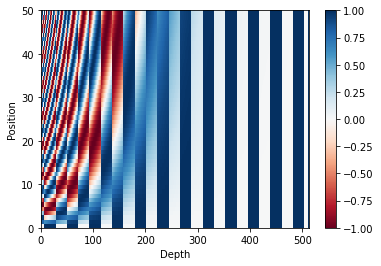

In [99]:
from matplotlib import pyplot as plt

def draw_pos_encoding(pos_encoding):
    plt.figure()
    plt.pcolormesh(pos_encoding[0], cmap='RdBu') # 绘制分类图
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar() # 条形bar颜色图例
    plt.savefig(cwd+'imgs/pos_encoding.png')
    plt.show()

draw_pos_encoding(pos_encoding)

## 3.掩码 masking
这里用到的mask有2种：
- padding mask：mask pad，即句子中为pad(value=0)的位置处其mask值为1
- look-ahead mask：mask future token，将当前token后面的词mask掉，只让看到前面的词，即future token位置的mask值为1

**【注意】：** 因为我这里使用的是torchtext里的tokenizer,从前面可以看出它的词表里pad的index=1，而不是常规的0。
这里要特别注意，不然容易出错！

In [13]:
pad = 1 # 重要！
def create_padding_mask(seq):  # seq [b, seq_len]
    # seq = torch.eq(seq, torch.tensor(0)).float() # pad=0的情况
    seq = torch.eq(seq, torch.tensor(pad)).float()  # pad!=0
    return seq[:, np.newaxis, np.newaxis, :]  # =>[b, 1, 1, seq_len]

x = torch.tensor([[7, 6, 0, 0, 1],
                  [1, 2, 3, 0, 0],
                  [0, 0, 0, 4, 5]])
print(x.shape) # [3,5]
print(x)
mask = create_padding_mask(x)
print(mask.shape, mask.dtype) # [3,1,1,5]
print(mask)

torch.Size([3, 5])
tensor([[7, 6, 0, 0, 1],
        [1, 2, 3, 0, 0],
        [0, 0, 0, 4, 5]])
torch.Size([3, 1, 1, 5]) torch.float32
tensor([[[[0., 0., 0., 0., 1.]]],


        [[[1., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.]]]])


In [14]:
# torch.triu(tensor, diagonal=0) 求上三角矩阵，diagonal默认为0表示主对角线的上三角矩阵
# diagonal>0，则主对角上面的第|diagonal|条次对角线的上三角矩阵
# diagonal<0，则主对角下面的第|diagonal|条次对角线的上三角矩阵
def create_look_ahead_mask(size):  # seq_len
    mask = torch.triu(torch.ones((size, size)), diagonal=1)
    # mask = mask.device() #
    return mask  # [seq_len, seq_len]

x = torch.rand(1,3)
print(x.shape)
print(x)
mask = create_look_ahead_mask(x.shape[1])
print(mask.shape, mask.dtype)
print(mask)

torch.Size([1, 3])
tensor([[0.8287, 0.6121, 0.3410]])
torch.Size([3, 3]) torch.float32
tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])


## 4.scaled dot product attention
![jupyter-img2](./imgs/im2.jpg)

$$Attention(Q,K,V)=softmax_{(k)}(\frac{QK^T}{\sqrt{d_k}})V$$

注意：实现时对mask的处理

mask=1的位置是pad或者future token，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0

In [15]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    #计算注意力权重。
    q, k, v 必须具有匹配的前置维度。 且dq=dk
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    #虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    #但是 mask 必须能进行广播转换以便求和。

    #参数:
        q: 请求的形状 == (..., seq_len_q, depth)
        k: 主键的形状 == (..., seq_len_k, depth)
        v: 数值的形状 == (..., seq_len_v, depth_v)  seq_len_k = seq_len_v
        mask: Float 张量，其形状能转换成
              (..., seq_len_q, seq_len_k)。默认为None。

    #返回值:
        #输出，注意力权重
    """
    # matmul(a,b)矩阵乘:a b的最后2个维度要能做乘法，即a的最后一个维度值==b的倒数第2个纬度值，
    # 除此之外，其他维度值必须相等或为1（为1时会广播）
    matmul_qk = torch.matmul(q, k.transpose(-1, -2))  # 矩阵乘 =>[..., seq_len_q, seq_len_k]

    # 缩放matmul_qk
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)  # k的深度dk，或叫做depth_k
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)  # [..., seq_len_q, seq_len_k]

    # 将 mask 加入到缩放的张量上(重要！)
    if mask is not None:  # mask: [b, 1, 1, seq_len]
        # mask=1的位置是pad，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0
        scaled_attention_logits += (mask * -1e9)

    # softmax 在最后一个轴（seq_len_k）上归一化
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # [..., seq_len_q, seq_len_k]

    output = torch.matmul(attention_weights, v)  # =>[..., seq_len_q, depth_v]
    return output, attention_weights  # [..., seq_len_q, depth_v], [..., seq_len_q, seq_len_k]

In [103]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

np.set_printoptions(suppress=True) # 设置不以科学计数法的形式显示数据

temp_k = torch.tensor([[10,0,0],
                       [0,10,0],
                       [0,0,10],
                       [0,0,10]], dtype=torch.float32) # [4,3]
temp_v = torch.tensor([[1,0],
                       [10,0],
                       [100,5],
                       [1000,6]], dtype=torch.float32) #[4,2]

In [27]:
# query aligns with第2个key (key的第2列)，得到attention weights：[0. 1. 0. 0.]
# 所以第2行 的value值被返回
temp_q = torch.tensor([[0,10,0]], dtype=torch.float32) # [1,3]
print_out(temp_q, temp_k, temp_v)
# Attention weights：[0. 1. 0. 0.]， Output：[[10.  0.]]

Attention weights are:
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])
Output is:
tensor([[1.0000e+01, 9.2766e-25]])


In [28]:
# query aligns with 重复的key (key的第3列和第4列)，得到attention weights：[0. 0. 0.5 0.5]
# 所以第3行的value值与第4行的value值平均化后，被返回 【(100+1000)/2=550, (5+6)/2=5.5】
temp_q = torch.tensor([[0,0,10]], dtype=torch.float32) # [1,3]
print_out(temp_q, temp_k, temp_v)
# Attention weights：[0. 0. 0.5 0.5]， Output：[[550.  5.5]]

Attention weights are:
tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01]])
Output is:
tensor([[550.0000,   5.5000]])


In [29]:
# query aligns with 第1个key (key的第1列)和第2个key (key的第2列)，得到attention weights：[0.5 0.5 0. 0.]
# 所以第1行的value值与第2行的value值平均化后，被返回 【(1+10)/2=5.5, (0.+0.)/2=0.】
temp_q = torch.tensor([[10,10,0]], dtype=torch.float32) # [1,3]
print_out(temp_q, temp_k, temp_v)
# Attention weights：[0.5 0.5 0. 0.]， Output：[[5.5.  0.]]

Attention weights are:
tensor([[5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+00, 4.6383e-25]])


In [30]:
# 传入所有的query
temp_q = torch.tensor([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=torch.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)
"""
# Attention weights：tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)，
# Output：tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)
"""

Attention weights are:
tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01],
        [8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26],
        [5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+02, 5.5000e+00],
        [1.0000e+01, 9.2766e-25],
        [5.5000e+00, 4.6383e-25]])


'\n# Attention weights：tensor(\n[[0.  0.  0.5 0.5]\n [0.  1.  0.  0. ]\n [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)，\n# Output：tensor(\n[[550.    5.5]\n [ 10.    0. ]\n [  5.5   0. ]], shape=(3, 2), dtype=float32)\n'

## 5.multi-head attention
![jupyter-img3](./imgs/im3.jpg)

多头注意允许模型在不同的位置联合处理来自不同表示子空间的信息。
（Multi-head attention allows the model to jointly attend to information
from different representation subspaces at different positions.）

$$\begin{array}{ll}  & MultiHead(Q,K,V)=Concat(head_1,...,head_h)W^O \\ & where\; head_i=Attention(QW_i^Q,KW_i^K,VW_i^V)\end{array}$$

其中投影维参数矩阵$W_i^Q\in R^{d_{model}\text{x}\,d_k}$，$W_i^K\in R^{d_{model}\text{x}\,d_k}$， $W_i^V\in R^{d_{model}\text{x}\,d_v}$，$W^O\in R^{hd_v\text{x}\,d_{model}}$。

$h=8,\;d_k = d_v = d_{model}/h = 64$

multi-head attention有4部分组成：
- linear layer 将 linear layer的结果 split到不同的head
- scaled dot-product attention
- 将所有的head 进行拼接 concat
- final linear layer

In [16]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0  # 因为输入要被（平均？）split到不同的head

        self.depth = d_model // self.num_heads  # 512/8=64，所以在scaled dot-product atten中dq=dk=64,dv也是64

        self.wq = torch.nn.Linear(d_model, d_model)
        self.wk = torch.nn.Linear(d_model, d_model)
        self.wv = torch.nn.Linear(d_model, d_model)

        self.final_linear = torch.nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):  # x [b, seq_len, d_model]
        x = x.view(batch_size, -1, self.num_heads,
                   self.depth)  # [b, seq_len, d_model=512]=>[b, seq_len, num_head=8, depth=64]
        return x.transpose(1, 2)  # [b, seq_len, num_head=8, depth=64]=>[b, num_head=8, seq_len, depth=64]

    def forward(self, q, k, v, mask):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model
        batch_size = q.shape[0]

        q = self.wq(q)  # =>[b, seq_len, d_model]
        k = self.wk(k)  # =>[b, seq_len, d_model]
        v = self.wv(v)  # =>[b, seq_len, d_model]

        q = self.split_heads(q, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
        k = self.split_heads(k, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
        v = self.split_heads(v, batch_size)  # =>[b, num_head=8, seq_len, depth=64]

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # => [b, num_head=8, seq_len_q, depth=64], [b, num_head=8, seq_len_q, seq_len_k]

        scaled_attention = scaled_attention.transpose(1, 2)  # =>[b, seq_len_q, num_head=8, depth=64]
        # 转置操作让张量存储结构扭曲，直接使用view方法会失败，可以使用reshape方法
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)  # =>[b, seq_len_q, d_model=512]

        output = self.final_linear(concat_attention)  # =>[b, seq_len_q, d_model=512]
        return output, attention_weights  # [b, seq_len_q, d_model=512], [b, num_head=8, seq_len_q, seq_len_k]


temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
x = torch.rand(1, 60, 512) # [b,seq_len,d_model,embedding_dim]
print(x.shape)
out, attn_weights = temp_mha(x, x, x, mask=None)
print(out.shape, attn_weights.shape) # [1, 60, 512], [1, 8, 60, 60]

torch.Size([1, 60, 512])
torch.Size([1, 60, 512]) torch.Size([1, 8, 60, 60])


## 6.point wise feed forward network
2层线性变换和一个ReLU激活：
$$FFN(x) = max(0, xW1 + b1)W2 + b2$$

这一层的input和output的维度都是$d_{model}$，而内层的维度的是$d_{ff}=2048$

其实就是(nn.relu(x w1+b1))w2+b2

In [17]:
# 点式前馈网络
def point_wise_feed_forward_network(d_model, dff):
    feed_forward_net = torch.nn.Sequential(
        torch.nn.Linear(d_model, dff),  # [b, seq_len, d_model]=>[b, seq_len, dff=2048]
        torch.nn.ReLU(),
        torch.nn.Linear(dff, d_model),  # [b, seq_len, dff=2048]=>[b, seq_len, d_model=512]
    )
    return feed_forward_net

sample_ffn = point_wise_feed_forward_network(512, 2048)
input = torch.rand(64, 50, 512) # [b, seq_len, d_model]
print(sample_ffn(input).shape) # [b=64, seq_len=50, d_model=512]


torch.Size([64, 50, 512])


transformer model:

(1) input sentence 传入N个encoder layer，句子的每个token都会有一个输出

(2) decoder attends on encoder 的输出（encoder-decoder attention） 和 它自己的输入（self-attention），然后预测出下一个词

## 7.encoder layer
每个编码器层包括以下2个子层：
- 多头注意力（有padding mask）
- 点式前馈网络（Point wise feed forward networks）

注意：每个子层还伴随着一个残差连接，然后进行“层归一化”（LayerNorm）。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。

注意：实现时在每个sub layer 之后加入了dropout层，再才进行add the sub layer input 和 normalized，即
LayerNorm(x + Dropout(Sublayer(x)))

Transformer 中有 N 个编码器层。

In [18]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)  # 多头注意力（padding mask）(self-attention)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)

    # x [b, inp_seq_len, embedding_dim] embedding_dim其实也=d_model
    # mask [b,1,1,inp_seq_len]
    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # =>[b, seq_len, d_model]
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # 残差&层归一化 =>[b, seq_len, d_model]

        ffn_output = self.ffn(out1)  # =>[b, seq_len, d_model]
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # 残差&层归一化 =>[b, seq_len, d_model]

        return out2  # [b, seq_len, d_model]

# layernorm = torch.nn.LayerNorm(normalized_shape=512, eps=1e-6)
# x = torch.rand(4, 50, 512)
# print(layernorm(x).shape)

sample_encoder_layer = EncoderLayer(512, 8, 2048)
x = torch.rand(64, 50, 512) # [b, seq_len, d_model]
sample_encoder_layer_output = sample_encoder_layer(x, None)
print(sample_encoder_layer_output.shape) # [64, 50, 512]

torch.Size([64, 50, 512])


## 8.decoder layer

每个解码器层包括以下3个子层：
- masked的多头注意力（look ahead mask 和 padding mask）(self-attention)
- 多头注意力（padding mask）(encoder-decoder attention)。
    V和 K接收encoder的输出作为输入。Q接收masked的多头注意力子层的输出。
- 点式前馈网络

每个子层还伴随着一个残差连接，然后进行“层归一化”（LayerNorm）。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到decoder的第一个注意力块的输出，并且 K 接收到encoder的输出时，注意力权重表示根据encoder的输出赋予decoder输入的重要性。
换一种说法，decoder通过查看encoder输出和对其自身输出的自注意力，预测下一个词。

In [19]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model,
                                       num_heads)  # masked的多头注意力（look ahead mask 和 padding mask）(self-attention)
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # 多头注意力（padding mask）(encoder-decoder attention)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm3 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)
        self.dropout3 = torch.nn.Dropout(rate)

    # x [b, targ_seq_len, embedding_dim] embedding_dim其实也=d_model=512
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len] 这里传入的look_ahead_mask应该是已经结合了look_ahead_mask和padding mask的mask
    # enc_output [b, inp_seq_len, d_model]
    # padding_mask [b, 1, 1, inp_seq_len]
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x,
                                               look_ahead_mask)  # =>[b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len]
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)  # 残差&层归一化 [b, targ_seq_len, d_model]

        # Q: receives the output from decoder's first attention block，即 masked multi-head attention sublayer
        # K V: V (value) and K (key) receive the encoder output as inputs
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output,
                                               padding_mask)  # =>[b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, inp_seq_len]
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)  # 残差&层归一化 [b, targ_seq_len, d_model]

        ffn_output = self.ffn(out2)  # =>[b, targ_seq_len, d_model]
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(out2 + ffn_output)  # 残差&层归一化 =>[b, targ_seq_len, d_model]

        return out3, attn_weights_block1, attn_weights_block2
        # [b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len], [b, num_heads, targ_seq_len, inp_seq_len]


sample_decoder_layer = DecoderLayer(512, 8, 2048) #
y = torch.rand(64, 40, 512) # [b, seq_len, d_model]
sample_decoder_layer_output,_,_ = sample_decoder_layer(y, sample_encoder_layer_output, None, None)
print(sample_decoder_layer_output.shape) # [64, 40, 512]

torch.Size([64, 40, 512])


## 9.encoder
编码器 包括：
- 输入嵌入（Input Embedding）
- 位置编码（Positional Encoding）
- N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入

注意：缩放 embedding

原始论文的3.4节Embeddings and Softmax最后一句有提到： In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.

In [20]:
class Encoder(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 input_vocab_size,  # 输入词表大小（源语言（法语））
                 maximun_position_encoding,
                 rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = torch.nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding,
                                                d_model)  # =>[1, max_pos_encoding, d_model=512]

        # self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate).cuda() for _ in range(num_layers)] # 不行
        self.enc_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

        self.dropout = torch.nn.Dropout(rate)

    # x [b, inp_seq_len]
    # mask [b, 1, 1, inp_sel_len]
    def forward(self, x, mask):
        inp_seq_len = x.shape[-1]

        # adding embedding and position encoding
        x = self.embedding(x)  # [b, inp_seq_len]=>[b, inp_seq_len, d_model]
        # 缩放 embedding 原始论文的3.4节有提到： In the embedding layers, we multiply those weights by \sqrt{d_model}.
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        pos_encoding = self.pos_encoding[:, :inp_seq_len, :]
        pos_encoding = pos_encoding.cuda()  # ###############
        x += pos_encoding  # [b, inp_seq_len, d_model]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)  # [b, inp_seq_len, d_model]=>[b, inp_seq_len, d_model]
        return x  # [b, inp_seq_len, d_model]


sample_encoder = Encoder(num_layers=2,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         input_vocab_size=8500,
                         maximun_position_encoding=10000)
sample_encoder = sample_encoder.to(device)

x = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42))) # [b, seq_len]
# print(x.shape)
sample_encoder_output = sample_encoder(x.cuda(), None)
print(sample_encoder_output.shape) # [b, seq_len, d_model]

torch.Size([64, 42, 512])


## 10.decoder
解码器包括：
- 输出嵌入（Output Embedding）
- 位置编码（Positional Encoding）

N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [21]:
class Decoder(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 target_vocab_size,  # target词表大小（目标语言（英语））
                 maximun_position_encoding,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = torch.nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding,
                                                d_model)  # =>[1, max_pos_encoding, d_model=512]

        # self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate).cuda() for _ in range(num_layers)] # 不行
        self.dec_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

        self.dropout = torch.nn.Dropout(rate)

    # x [b, targ_seq_len]
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len] 这里传入的look_ahead_mask应该是已经结合了look_ahead_mask和padding mask的mask
    # enc_output [b, inp_seq_len, d_model]
    # padding_mask [b, 1, 1, inp_seq_len]
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        targ_seq_len = x.shape[-1]

        attention_weights = {}

        # adding embedding and position encoding
        x = self.embedding(x)  # [b, targ_seq_len]=>[b, targ_seq_len, d_model]
        # 缩放 embedding 原始论文的3.4节有提到： In the embedding layers, we multiply those weights by \sqrt{d_model}.
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        # x += self.pos_encoding[:, :targ_seq_len, :]  # [b, targ_seq_len, d_model]
        pos_encoding = self.pos_encoding[:, :targ_seq_len, :]  # [b, targ_seq_len, d_model]
        pos_encoding = pos_encoding.cuda() # ###############
        x += pos_encoding  # [b, inp_seq_len, d_model]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, attn_block1, attn_block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            # => [b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len], [b, num_heads, targ_seq_len, inp_seq_len]

            attention_weights[f'decoder_layer{i + 1}_block1'] = attn_block1
            attention_weights[f'decoder_layer{i + 1}_block2'] = attn_block2

        return x, attention_weights
        # => [b, targ_seq_len, d_model],
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

sample_decoder = Decoder(num_layers=2,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         target_vocab_size=8000,
                         maximun_position_encoding=5000)
sample_decoder = sample_decoder.to(device)

y = torch.tensor(np.random.randint(low=0, high=200, size=(64, 36))) # [b, seq_len]
# print(y.shape) # [64, 36]
output, attn = sample_decoder(y.cuda(),
                              enc_output=sample_encoder_output, # [64, 42, 512]
                              look_ahead_mask=None,
                              padding_mask=None)
print(output.shape) # [64, 36, 512]
print(attn['decoder_layer2_block1'].shape) # [64, 8, 36, 36]
print(attn['decoder_layer2_block2'].shape) # [64, 8, 36, 42]

torch.Size([64, 36, 512])
torch.Size([64, 8, 36, 36])
torch.Size([64, 8, 36, 42])


## 11.搭建transformer
transformer 含有3各部分
- encoder
- decoder
- final linear layer

In [22]:
class Transformer(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 input_vocab_size,  # input此表大小（源语言（法语））
                 target_vocab_size,  # target词表大小（目标语言（英语））
                 pe_input,  # input max_pos_encoding
                 pe_target,  # input max_pos_encoding
                 rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers,
                               d_model,
                               num_heads,
                               dff,
                               input_vocab_size,
                               pe_input,
                               rate)
        self.decoder = Decoder(num_layers,
                               d_model,
                               num_heads,
                               dff,
                               target_vocab_size,
                               pe_target,
                               rate)
        self.final_layer = torch.nn.Linear(d_model, target_vocab_size)

    # inp [b, inp_seq_len]
    # targ [b, targ_seq_len]
    # enc_padding_mask [b, 1, 1, inp_seq_len]
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len]
    # dec_padding_mask [b, 1, 1, inp_seq_len] # 注意这里的维度是inp_seq_len
    def forward(self, inp, targ, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, enc_padding_mask)  # =>[b, inp_seq_len, d_model]

        dec_output, attention_weights = self.decoder(targ, enc_output, look_ahead_mask, dec_padding_mask)
        # => [b, targ_seq_len, d_model],
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}
        final_output = self.final_layer(dec_output)  # =>[b, targ_seq_len, target_vocab_size]

        return final_output, attention_weights
        # [b, targ_seq_len, target_vocab_size]
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}


sample_transformer = Transformer(num_layers=2,
                                 d_model=512,
                                 num_heads=8,
                                 dff=2048,
                                 input_vocab_size=8500,
                                 target_vocab_size=8000,
                                 pe_input=10000,
                                 pe_target=6000)
sample_transformer = sample_transformer.to(device)

temp_inp = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42))) # [b, inp_seq_len]
temp_targ = torch.tensor(np.random.randint(low=0, high=200, size=(64, 36))) # [b, targ_seq_len]

fn_out, attn = sample_transformer(temp_inp.cuda(), temp_targ.cuda(), None, None, None)
print(fn_out.shape) # [64, 36, 8000]
print(attn['decoder_layer2_block1'].shape) # [64, 8, 36, 36]
print(attn['decoder_layer2_block2'].shape) # [64, 8, 36, 42]

torch.Size([64, 36, 8000])
torch.Size([64, 8, 36, 36])
torch.Size([64, 8, 36, 42])


## 12.设置超参

In [23]:
#Transformer 的基础模型使用的数值为：num_layers=6，d_model = 512，dff = 2048
#为了让本示例小且相对较快，已经减小了num_layers、 d_model 和 dff 的值。
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(SRC_TEXT.vocab) # 3901
target_vocab_size = len(TARG_TEXT.vocab) # 2591
dropout_rate = 0.1

print(input_vocab_size, target_vocab_size)

3901 2591


## 13.优化器
根据论文中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$lrate = d_{model}^{-0.5} * min(\text{step_num}^{-0.5},\; \text{step_num}*\text{warmup_steps}^{-1.5})$$

关于pytorch optimizer，参考：

https://www.cnblogs.com/wanghui-garcia/p/10895397.html

https://www.jianshu.com/p/5d85a59f1bac

In [24]:
class CustomSchedule(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, d_model, warm_steps=4):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warm_steps

        super(CustomSchedule, self).__init__(optimizer)

    def get_lr(self):
        """
        # rsqrt 函数用于计算 x 元素的平方根的倒数.  即= 1 / sqrt{x}
        arg1 = torch.rsqrt(torch.tensor(self._step_count, dtype=torch.float32))
        arg2 = torch.tensor(self._step_count * (self.warmup_steps ** -1.5), dtype=torch.float32)
        dynamic_lr = torch.rsqrt(self.d_model) * torch.minimum(arg1, arg2)
        """
        # print('*'*27, self._step_count)
        arg1 = self._step_count ** (-0.5)
        arg2 = self._step_count * (self.warmup_steps ** -1.5)
        dynamic_lr = (self.d_model ** (-0.5)) * min(arg1, arg2)
        # print('dynamic_lr:', dynamic_lr)
        return [dynamic_lr for group in self.optimizer.param_groups]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


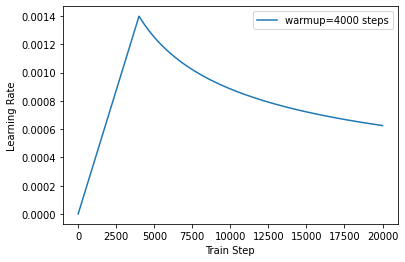

In [113]:
# 测试
model = sample_transformer
optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
learning_rate = CustomSchedule(optimizer, d_model, warm_steps=4000)

lr_list = []
for i in range(1, 20000):
    learning_rate.step()
    lr_list.append(learning_rate.get_lr()[0])
plt.figure()
plt.plot(np.arange(1, 20000), lr_list)
plt.legend(['warmup=4000 steps'])
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


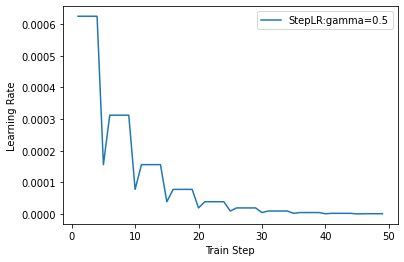

In [114]:
# 其他的学习率调度器测试，例如pytorch自带的StepLR
_model = sample_transformer
_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
_learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

lr_list = []
for i in range(1, 50):
    _learning_rate.step()
    lr_list.append(_learning_rate.get_lr()[0])
plt.figure()
plt.plot(np.arange(1, 50), lr_list)
plt.legend(['StepLR:gamma=0.5'])
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## 14.损失和评价准则

计算loss时要把mask=1的位置的去除掉

### 【大坑！】
【注意】，当输入是多维时交叉熵的参数维度，跟tf2不一样，tf2中pred是【b,seq_len,vocab_size】
pytorch中pred应该调整为【b,vocab_size,seq_len】

In [25]:
# 'none'表示直接返回b个样本的loss，默认求平均
loss_object = torch.nn.CrossEntropyLoss(reduction='none')
# 【注意】，当输入是多维时交叉熵的参数维度，跟tf2不一样，tf2中pred是【b,seq_len,vocab_size】
# pytorch中pred应该调整为【b,vocab_size,seq_len】
"""
- Input: :math:`(N, C)` where `C = number of classes`, or
          :math:`(N, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1`
          in the case of `K`-dimensional loss.

- Target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`, or
          :math:`(N, d_1, d_2, ..., d_K)` with :math:`K \geq 1` in the case of
          K-dimensional loss.
"""

# real [b, targ_seq_len]
# pred [b, targ_seq_len, target_vocab_size]
def mask_loss_func(real, pred):
    # print(real.shape, pred.shape)
    # _loss = loss_object(pred, real) # [b, targ_seq_len]
    _loss = loss_object(pred.transpose(-1, -2), real)  # [b, targ_seq_len]

    # logical_not  取非
    # mask 每个元素为bool值，如果real中有pad，则mask相应位置就为False
    # mask = torch.logical_not(real.eq(0)).type(_loss.dtype) # [b, targ_seq_len] pad=0的情况
    mask = torch.logical_not(real.eq(pad)).type(_loss.dtype)  # [b, targ_seq_len] pad!=0的情况

    # 对应位置相乘，token上的损失被保留了下来，pad的loss被置为0或False 去掉，不计算在内
    _loss *= mask

    return _loss.sum() / mask.sum().item()

# 另一种实现方式
def mask_loss_func2(real, pred):
    # _loss = loss_object(pred, real) # [b, targ_seq_len]
    _loss = loss_object(pred.transpose(-1, -2), real)  # [b, targ_seq_len]
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值
    mask = torch.logical_not(real.eq(pad)) # [b, targ_seq_len] bool值
    _loss = _loss.masked_select(mask) # mask必须是BoolTensor或ByteTensor类型
    return _loss.mean()


y_pred = torch.randn(3,3) # [3,3]
y_true = torch.tensor([1,2,0]) # [3]
# print(y_true.shape, y_pred.shape)
print(loss_object(y_pred, y_true))
print('计算loss时把mask的也算进去了,损失会偏大？：', loss_object(y_pred, y_true).mean())
print('计算loss时去除mask:', mask_loss_func(y_true, y_pred))
print('计算loss时去除mask:', mask_loss_func2(y_true, y_pred))

tensor([3.7972, 1.0699, 0.8568])
计算loss时把mask的也算进去了,损失会偏大？： tensor(1.9080)
计算loss时去除mask: tensor(1.2441)
计算loss时去除mask: tensor(1.2441)


同样计算metric（如acc）时要把mask=1的位置的去除掉

In [26]:
# real [b, targ_seq_len]
# pred [b, targ_seq_len, target_vocab_size]
def mask_accuracy_func(real, pred):
    _pred = pred.argmax(dim=-1)  # [b, targ_seq_len, target_vocab_size]=>[b, targ_seq_len]
    corrects = _pred.eq(real)  # [b, targ_seq_len] bool值

    # logical_not  取非
    # mask 每个元素为bool值，如果real中有pad，则mask相应位置就为False
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值 pad=0的情况
    mask = torch.logical_not(real.eq(pad))  # [b, targ_seq_len] bool值 pad!=0的情况

    # 对应位置相乘，token上的值被保留了下来，pad上的值被置为0或False 去掉，不计算在内
    corrects *= mask

    return corrects.sum().float() / mask.sum().item()

# 另一种实现方式
def mask_accuracy_func2(real, pred):
    _pred = pred.argmax(dim=-1) # [b, targ_seq_len, target_vocab_size]=>[b, targ_seq_len]
    corrects = _pred.eq(real).type(torch.float32) # [b, targ_seq_len]
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值
    mask = torch.logical_not(real.eq(pad)) # [b, targ_seq_len] bool值
    corrects = corrects.masked_select(mask) # [真正有token的个数] 平摊开成1维的

    return corrects.mean()

def mask_accuracy_func3(real, pred):
    _pred = pred.argmax(dim=-1) # [b, targ_seq_len, target_vocab_size]=>[b, targ_seq_len]
    corrects = _pred.eq(real) # [b, targ_seq_len] bool值
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值
    mask = torch.logical_not(real.eq(pad)) # [b, targ_seq_len] bool值
    corrects = torch.logical_and(corrects, mask)
    # print(corrects.dtype) # bool
    # print(corrects.sum().dtype) #int64
    return corrects.sum().float()/mask.sum().item()

y_pred = torch.randn(3,3) # [3,3]
y_true = torch.tensor([0,2,1]) # [3] 最后一个1表示pad噢~
print(y_true)
print(y_pred)
print('计算acc时去除mask:', mask_accuracy_func(y_true, y_pred))
print('计算acc时去除mask:', mask_accuracy_func2(y_true, y_pred))
print('计算acc时去除mask:', mask_accuracy_func3(y_true, y_pred))

tensor([0, 2, 1])
tensor([[-0.3903,  1.7641,  0.5455],
        [ 1.0297, -1.5503, -1.5172],
        [ 0.8182,  1.1333, -0.4007]])
计算acc时去除mask: tensor(0.)
计算acc时去除mask: tensor(0.)
计算acc时去除mask: tensor(0.)


## 15.生成mask

$$Attention(Q,K,V)=softmax_{(k)}(\frac{QK^T}{\sqrt{d_k}})V$$

注意：实现时对mask的处理

mask=1的位置是pad或者future token，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0

【注意】：在计算decoder的第2个attention block时（encoder-decoder attention），
从scaled dot-product的公式可以看出，此时Q是decoder的第一个attention block的输出，
而K，V都来自encoder的输出。QK^T后得到[...,seq_len_q, seq_len_k]，而softmax是在seq_len_k维
上进行的，softmax后seq_len_k维上pad的位置被置于0，乘以V（seq_len_k=seq_len_v=encoder output的seq_len）
后那些pad的位置还是只会是0。所以仅从公式就可以看出decoder的第2个attention block的padding mask是基于
encoder output 的seq_len即整个模型的inp_seq_len来设置的，而不是targ_seq_len。

从注意力角度来看，可以理解成：当 Q 接收到decoder的第一个注意力块的输出，并且 K 接收到encoder的输出时，注意力权重表示根据encoder的输出赋予decoder输入的重要性。
换一种说法，decoder通过查看encoder输出和对其自身输出的自注意`力，预测下一个词。

另外 padding mask 的维度是[b,1,1,seq_len] 一般只关注最后一个seq_len维度上pad(无论是在
self-attention 或者encoder-decoder attention上都比较容易理解)

而 look-ahead mask 是decoder self-attention时用于mask future token的，因为是“自”注意力，
所以维度是[...,seq_len, seq_len]，需要自己跟自己运算，所以在QK（此时Q=K=V）矩阵乘的结果的最后2个维度上都需要mask

In [27]:
# inp [b, inp_seq_len] 序列已经加入pad填充
# targ [b, targ_seq_len] 序列已经加入pad填充
def create_mask(inp, targ):
    # encoder padding mask
    enc_padding_mask = create_padding_mask(inp)  # =>[b,1,1,inp_seq_len] mask=1的位置为pad

    # decoder's first attention block(self-attention)
    # 使用的padding create_mask & look-ahead create_mask
    look_ahead_mask = create_look_ahead_mask(targ.shape[-1])  # =>[targ_seq_len,targ_seq_len] ##################
    dec_targ_padding_mask = create_padding_mask(targ)  # =>[b,1,1,targ_seq_len]
    combined_mask = torch.max(look_ahead_mask, dec_targ_padding_mask)  # 结合了2种mask =>[b,1,targ_seq_len,targ_seq_len]

    # decoder's second attention block(encoder-decoder attention) 使用的padding create_mask
    # 【注意】：这里的mask是用于遮挡encoder output的填充pad，而encoder的输出与其输入shape都是[b,inp_seq_len,d_model]
    # 所以这里mask的长度是inp_seq_len而不是targ_mask_len
    dec_padding_mask = create_padding_mask(inp)  # =>[b,1,1,inp_seq_len] mask=1的位置为pad

    return enc_padding_mask, combined_mask, dec_padding_mask
    # [b,1,1,inp_seq_len], [b,1,targ_seq_len,targ_seq_len], [b,1,1,inp_seq_len]

## 16.训练和保存

### 配置检查点 save_dir

In [28]:
save_dir = cwd + './save/'

transformer = Transformer(num_layers,
                          d_model,
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

print(transformer) # 打印模型基本信息

transformer = transformer.to(device)
if ngpu > 1: # 并行化
    transformer = torch.nn.DataParallel(transformer,  device_ids=list(range(ngpu))) # 设置并行执行  device_ids=[0,1]

optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
lr_scheduler = CustomSchedule(optimizer, d_model, warm_steps=4000)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(3901, 128)
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (wq): Linear(in_features=128, out_features=128, bias=True)
          (wk): Linear(in_features=128, out_features=128, bias=True)
          (wv): Linear(in_features=128, out_features=128, bias=True)
          (final_linear): Linear(in_features=128, out_features=128, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (layernorm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (layernorm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (mha): MultiHeadAttention(
          (wq): Linear(in_

In [29]:
# 关于position encoding的一点自己的理解：
"""
为什么这里传入的pe_input是input_vocab_size，也就是说position encoding传入的pos参数是词表大小
而我一开始理解的max_seq_len的大小，所以才在encoder中获取位置编码是self.pos_encoding[:, :seq_len, :]
但知道看到这里传入的是词表大小我才发现我理解错了

其实position encoding 就跟embedding 一样，就是【vocab_size x d_model】的
但此时另一个问题又出现了，那为什么在获取position encoding时 使用的是pos_encoding[:, :seq_len, :]而不是
像embedding一样 去look-up 查询每个token的位置表示呢？而是直接取得前seq_len个表示作为位置表示？

这就体现了这种位置编码的巧妙之处，他不需要训练，就能独特的表示每一个单独的token，而每个token之间又存在关系
所以这并不需要位置编码和token是一一对应（固定死的），只需要位置编码能传达这2点信息（即token的独特性和相对依赖性）就够了
即使是同一个token 在一个句子的不同的位置时 他的位置编码当然也是不一样的了 如果像embedding那样去查 那一个句子的
不同位置的相同token  其表示就会是一样的  就体现不出位置关系

这样一想的话，似乎把pe_input设置成max_seq_len也是可以的。但是这里实现position encoding方式（sin  cos）
可以在测试阶段接受长度超过训练集实例的情况！所以干脆把pe_input设置成词表大小？
"""

# inp [b,inp_seq_len]
# targ [b,targ_seq_len]
"""
拆分targ, 例如：sentence = "SOS A lion in the jungle is sleeping EOS"
tar_inp = "<start>> A lion in the jungle is sleeping"
tar_real = "A lion in the jungle is sleeping <end>"
"""
def train_step(model, inp, targ):
    # 目标（target）被分成了 tar_inp 和 tar_real
    # tar_inp 作为输入传递到解码器。
    # tar_real 是位移了 1 的同一个输入：在 tar_inp 中的每个位置，tar_real 包含了应该被预测到的下一个标记（token）。
    targ_inp = targ[:, :-1]
    targ_real = targ[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, targ_inp)

    inp = inp.to(device)
    targ_inp = targ_inp.to(device)
    targ_real = targ_real.to(device)
    enc_padding_mask = enc_padding_mask.to(device)
    combined_mask = combined_mask.to(device)
    dec_padding_mask = dec_padding_mask.to(device)
    # print('device:', inp.device, targ_inp)

    model.train()  # 设置train mode

    optimizer.zero_grad()  # 梯度清零

    # forward
    prediction, _ = transformer(inp, targ_inp, enc_padding_mask, combined_mask, dec_padding_mask)
    # [b, targ_seq_len, target_vocab_size]
    # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
    #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

    loss = mask_loss_func(targ_real, prediction)
    metric = mask_accuracy_func(targ_real, prediction)

    # backward
    loss.backward()  # 反向传播计算梯度
    optimizer.step()  # 更新参数

    return loss.item(), metric.item()


# 检查train_step()的效果
batch_src, batch_targ = next(iter(train_dataloader)) # [64,10], [64,10]
print(train_step(transformer, batch_src, batch_targ))
"""
x += pos_encoding  # [b, inp_seq_len, d_model]
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!
"""

(8.07600212097168, 0.0)


'\nx += pos_encoding  # [b, inp_seq_len, d_model]\nRuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!\n'

In [30]:
def validate_step(model, inp, targ):
    targ_inp = targ[:, :-1]
    targ_real = targ[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, targ_inp)

    inp = inp.to(device)
    targ_inp = targ_inp.to(device)
    targ_real = targ_real.to(device)
    enc_padding_mask = enc_padding_mask.to(device)
    combined_mask = combined_mask.to(device)
    dec_padding_mask = dec_padding_mask.to(device)

    model.eval()  # 设置eval mode

    with torch.no_grad():
        # forward
        prediction, _ = model(inp, targ_inp, enc_padding_mask, combined_mask, dec_padding_mask)
        # [b, targ_seq_len, target_vocab_size]
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

        val_loss = mask_loss_func(targ_real, prediction)
        val_metric = mask_accuracy_func(targ_real, prediction)

    return val_loss.item(), val_metric.item()


In [155]:
EPOCHS = 40 # 50 # 30  # 20

print_trainstep_every = 50  # 每50个step做一次打印

metric_name = 'acc'
# df_history = pd.DataFrame(columns=['epoch', 'loss', metric_name]) # 记录训练历史信息
df_history = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_' + metric_name])


# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m_%d %H:%M:%S')
    print('\n' + "=========="*8 + '%s'%nowtime)

In [156]:
def train_model(model, epochs, train_dataloader, val_dataloader, print_every):
    starttime = time.time()
    print('*' * 27, 'start training...')
    printbar()

    best_acc = 0.
    for epoch in range(1, epochs + 1):

        # lr_scheduler.step() # 更新学习率

        loss_sum = 0.
        metric_sum = 0.

        for step, (inp, targ) in enumerate(train_dataloader, start=1):
            # inp [64, 10] , targ [64, 10]
            loss, metric = train_step(model, inp, targ)

            loss_sum += loss
            metric_sum += metric

            # 打印batch级别日志
            if step % print_every == 0:
                print('*' * 8, f'[step = {step}] loss: {loss_sum / step:.3f}, {metric_name}: {metric_sum / step:.3f}')

            lr_scheduler.step()  # 更新学习率

        # 一个epoch的train结束，做一次验证
        # test(model, train_dataloader)
        val_loss_sum = 0.
        val_metric_sum = 0.
        for val_step, (inp, targ) in enumerate(val_dataloader, start=1):
            # inp [64, 10] , targ [64, 10]
            loss, metric = validate_step(model, inp, targ)

            val_loss_sum += loss
            val_metric_sum += metric

        # 记录和收集1个epoch的训练（和验证）信息
        # record = (epoch, loss_sum/step, metric_sum/step)
        record = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        df_history.loc[epoch - 1] = record

        # 打印epoch级别的日志
        # print('*'*8, 'EPOCH = {} loss: {:.3f}, {}: {:.3f}'.format(
        #        record[0], record[1], metric_name, record[2]))
        print('EPOCH = {} loss: {:.3f}, {}: {:.3f}, val_loss: {:.3f}, val_{}: {:.3f}'.format(
            record[0], record[1], metric_name, record[2], record[3], metric_name, record[4]))
        printbar()

        # 保存模型
        # current_acc_avg = metric_sum / step
        current_acc_avg = val_metric_sum / val_step # 看验证集指标
        if current_acc_avg > best_acc:  # 保存更好的模型
            best_acc = current_acc_avg
            checkpoint = save_dir + '{:03d}_{:.2f}_ckpt.tar'.format(epoch, current_acc_avg)
            if device.type == 'cuda' and ngpu > 1:
                # model_sd = model.module.state_dict()  ##################
                model_sd = copy.deepcopy(model.module.state_dict())
            else:
                # model_sd = model.state_dict(),  ##################
                model_sd = copy.deepcopy(model.state_dict())  ##################
            torch.save({
                'loss': loss_sum / step,
                'epoch': epoch,
                'net': model_sd,
                'opt': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict()
            }, checkpoint)


    print('finishing training...')
    endtime = time.time()
    time_elapsed = endtime - starttime
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return df_history

In [157]:
# 开始训练
df_history = train_model(transformer, EPOCHS, train_dataloader, val_dataloader, print_trainstep_every)
print(df_history)

*************************** start training...

================================================================================2020-12_15 12:54:02
EPOCH = 1 loss: 7.786, acc: 0.006, val_loss: 7.445, val_acc: 0.119

================================================================================2020-12_15 12:54:08
EPOCH = 2 loss: 7.084, acc: 0.191, val_loss: 6.532, val_acc: 0.292

================================================================================2020-12_15 12:54:15
EPOCH = 3 loss: 6.306, acc: 0.293, val_loss: 5.850, val_acc: 0.336

================================================================================2020-12_15 12:54:21
EPOCH = 4 loss: 5.689, acc: 0.359, val_loss: 5.239, val_acc: 0.428

================================================================================2020-12_15 12:54:26
EPOCH = 5 loss: 5.135, acc: 0.415, val_loss: 4.753, val_acc: 0.422

================================================================================2020-12_15 12:54:33
EPOCH = 6 los

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


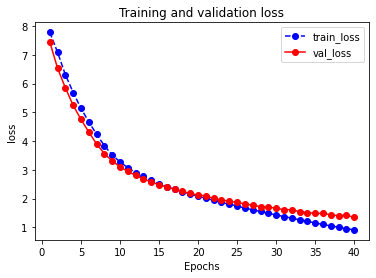

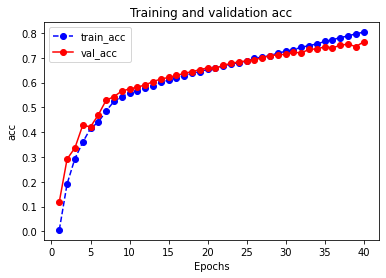

In [158]:
# 绘制训练曲线
def plot_metric(df_history, metric):
    plt.figure()

    train_metrics = df_history[metric]
    val_metrics = df_history['val_' + metric]  #

    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')  #

    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.savefig(cwd + 'imgs/' + metric + '.png')  # 保存图片
    plt.show()


plot_metric(df_history, 'loss')
plot_metric(df_history, metric_name)

## 17.评估
这里的评估 没有额外的使用测试集测评，还是拿验证集测试的。另外可以对一个法语句子进行翻译，看看翻译的结果如何

以下步骤用于评估：
- 用法语分词器（tokenizer_pt）编码输入语句。此外，添加<start>和<end>标记，这样输入就与模型训练的内容相同。这是编码器输入。
- 解码器输入为 <start> token id
- 计算padding mask 和 look ahead mask
- 解码器通过查看编码器输出和它自身的输出（自注意力）给出预测。
- 选择最后一个词并计算它的 argmax。
- 将预测的词concat到解码器输入，然后传递给解码器。
- 在这种方法中，解码器根据它之前预测的words预测下一个。

In [31]:
# 加载model
checkpoint = save_dir + '040_0.76_ckpt.tar'
print('checkpoint:', checkpoint)
# ckpt = torch.load(checkpoint, map_location=device)  # dict  save 在 CPU 加载到GPU
ckpt = torch.load(checkpoint)  # dict  save 在 GPU 加载到 GPU
# print('ckpt', ckpt)
transformer_sd = ckpt['net']
# optimizer_sd = ckpt['opt'] # 不重新训练的话不需要
# lr_scheduler_sd = ckpt['lr_scheduler']

reload_model = Transformer(num_layers,
                           d_model,
                           num_heads,
                           dff,
                           input_vocab_size,
                           target_vocab_size,
                           pe_input=input_vocab_size,
                           pe_target=target_vocab_size,
                           rate=dropout_rate)

reload_model = reload_model.to(device)
if ngpu > 1:
    reload_model = torch.nn.DataParallel(reload_model,  device_ids=list(range(ngpu))) # 设置并行执行  device_ids=[0,1]


print('Loading model ...')
if device.type == 'cuda' and ngpu > 1:
   reload_model.module.load_state_dict(transformer_sd)
else:
   reload_model.load_state_dict(transformer_sd)
print('Model loaded ...')

checkpoint: /home/xijian/pycharm_projects/DeepLearning/src/blogs/machine_translation/pytorch/transformer/./save/040_0.76_ckpt.tar
Loading model ...
Model loaded ...


In [34]:
def test(model, dataloader):
    # model.eval() # 设置为eval mode

    test_loss_sum = 0.
    test_metric_sum = 0.
    for test_step, (inp, targ) in enumerate(dataloader, start=1):
        # inp [64, 10] , targ [64, 10]
        loss, metric = validate_step(model, inp, targ)
        # print('*'*8, loss, metric)

        test_loss_sum += loss
        test_metric_sum += metric
    # 打印
    print('*' * 8,
          'Test: loss: {:.3f}, {}: {:.3f}'.format(test_loss_sum / test_step, 'test_acc', test_metric_sum / test_step))


# 在测试集上测试指标，这里使用val_dataloader模拟测试集
print('*' * 8, 'final test...')
test(reload_model, val_dataloader)


******** final test...
******** Test: loss: 1.343, test_acc: 0.765


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [37]:
def tokenizer_encode(tokenize, sentence, vocab):
    # print(type(vocab)) # torchtext.vocab.Vocab
    # print(len(vocab))
    sentence = normalizeString(sentence)
    # print(type(sentence)) # str
    sentence = tokenize(sentence)  # list
    sentence = ['<start>'] + sentence + ['<end>']
    sentence_ids = [vocab.stoi[token] for token in sentence]
    # print(sentence_ids, type(sentence_ids[0])) # int
    return sentence_ids


def tokenzier_decode(sentence_ids, vocab):
    sentence = [vocab.itos[id] for id in sentence_ids if id<len(vocab)]
    # print(sentence)
    return " ".join(sentence)

# 只有一个句子，不需要加pad
s = 'je pars en vacances pour quelques jours .'
print(tokenizer_encode(tokenizer, s, SRC_TEXT.vocab))


s_ids = [3, 5, 251, 17, 365, 35, 492, 390, 4, 2]
print(tokenzier_decode(s_ids, SRC_TEXT.vocab))
print(tokenzier_decode(s_ids, TARG_TEXT.vocab))

[3, 5, 251, 17, 365, 35, 492, 390, 4, 2]
<start> je pars en vacances pour quelques jours . <end>
<start> i tennis very forgetful me helping bed . <end>


In [40]:
# inp_sentence 一个法语句子，例如"je pars en vacances pour quelques jours ."
def evaluate(model, inp_sentence):
    model.eval()  # 设置eval mode

    inp_sentence_ids = tokenizer_encode(tokenizer, inp_sentence, SRC_TEXT.vocab)  # 转化为索引
    # print(tokenzier_decode(inp_sentence_ids, SRC_TEXT.vocab))
    encoder_input = torch.tensor(inp_sentence_ids).unsqueeze(dim=0)  # =>[b=1, inp_seq_len=10]
    # print(encoder_input.shape)

    decoder_input = [TARG_TEXT.vocab.stoi['<start>']]
    decoder_input = torch.tensor(decoder_input).unsqueeze(0)  # =>[b=1,seq_len=1]
    # print(decoder_input.shape)

    with torch.no_grad():
        for i in range(MAX_LENGTH + 2):
            enc_padding_mask, combined_mask, dec_padding_mask = create_mask(encoder_input.cpu(), decoder_input.cpu()) ################
            # [b,1,1,inp_seq_len], [b,1,targ_seq_len,inp_seq_len], [b,1,1,inp_seq_len]

            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            enc_padding_mask = enc_padding_mask.to(device)
            combined_mask = combined_mask.to(device)
            dec_padding_mask = dec_padding_mask.to(device)

            # forward
            predictions, attention_weights = model(encoder_input,
                                                   decoder_input,
                                                   enc_padding_mask,
                                                   combined_mask,
                                                   dec_padding_mask)
            # [b=1, targ_seq_len, target_vocab_size]
            # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
            #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

            # 看最后一个词并计算它的 argmax
            prediction = predictions[:, -1:, :]  # =>[b=1, 1, target_vocab_size]
            prediction_id = torch.argmax(prediction, dim=-1)  # => [b=1, 1]
            # print('prediction_id:', prediction_id, prediction_id.dtype) # torch.int64
            if prediction_id.squeeze().item() == TARG_TEXT.vocab.stoi['<end>']:
                return decoder_input.squeeze(dim=0), attention_weights

            decoder_input = torch.cat([decoder_input, prediction_id],
                                      dim=-1)  # [b=1,targ_seq_len=1]=>[b=1,targ_seq_len=2]
            # decoder_input在逐渐变长

    return decoder_input.squeeze(dim=0), attention_weights
    # [targ_seq_len],
    # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
    #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}



# s = 'je pars en vacances pour quelques jours .'
# evaluate(s)

s = 'je pars en vacances pour quelques jours .'
s_targ = 'i m taking a couple of days off .'
pred_result, attention_weights = evaluate(reload_model, s)
pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
print('real target:', s_targ)
print('pred_sentence:', pred_sentence)

real target: i m taking a couple of days off .
pred_sentence: <start> i m going on a couple of days off .


In [41]:
# 批量翻译
sentence_pairs = [
    ['je pars en vacances pour quelques jours .', 'i m taking a couple of days off .'],
    ['je ne me panique pas .', 'i m not panicking .'],
    ['je recherche un assistant .', 'i am looking for an assistant .'],
    ['je suis loin de chez moi .', 'i m a long way from home .'],
    ['vous etes en retard .', 'you re very late .'],
    ['j ai soif .', 'i am thirsty .'],
    ['je suis fou de vous .', 'i m crazy about you .'],
    ['vous etes vilain .', 'you are naughty .'],
    ['il est vieux et laid .', 'he s old and ugly .'],
    ['je suis terrifiee .', 'i m terrified .'],
]


def batch_translate(sentence_pairs):
    for pair in sentence_pairs:
        print('input:', pair[0])
        print('target:', pair[1])
        pred_result, _ = evaluate(reload_model, pair[0])
        pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
        print('pred:', pred_sentence)
        print('')

batch_translate(sentence_pairs)

input: je pars en vacances pour quelques jours .
target: i m taking a couple of days off .
pred: <start> i m going on a couple of days off .

input: je ne me panique pas .
target: i m not panicking .
pred: <start> i m not getting not getting involved .

input: je recherche un assistant .
target: i am looking for an assistant .
pred: <start> i m looking for a lot .

input: je suis loin de chez moi .
target: i m a long way from home .
pred: <start> i m at home .

input: vous etes en retard .
target: you re very late .
pred: <start> you re late .

input: j ai soif .
target: i am thirsty .
pred: <start> i m thirsty .

input: je suis fou de vous .
target: i m crazy about you .
pred: <start> i m crazy about you .

input: vous etes vilain .
target: you are naughty .
pred: <start> you re foolish .

input: il est vieux et laid .
target: he s old and ugly .
pred: <start> he s old and old and old .

input: je suis terrifiee .
target: i m terrified .
pred: <start> i m being promoted .



In [42]:
# 随机选个句子翻译
def evaluateRandomly(n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('input:', pair[0])
        print('target:', pair[1])
        pred_result, attentions = evaluate(reload_model, pair[0])
        pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
        print('pred:', pred_sentence)
        print('')


evaluateRandomly(5)

input: elle est toujours habillee en noir .
target: she is always dressed in black .
pred: <start> she is always on their minds .

input: il devient chauve .
target: he s going bald .
pred: <start> he s going to get married .

input: c est pour vous que je suis venu .
target: you re the reason i came .
pred: <start> i m worried about you .

input: je suis desole de t avoir hurle dessus .
target: i m sorry i yelled at you .
pred: <start> i m sorry i hurt you .

input: elle n est pas apte pour le poste .
target: she isn t fit for the job .
pred: <start> she is not doing it for the job .



## 18.attention 的可视化

In [43]:
# 可视化attenton 这里我们只展示...block2的attention，即[b, num_heads, targ_seq_len, inp_seq_len]
# attention: {'decoder_layer{i + 1}_block1': [b, num_heads, targ_seq_len, targ_seq_len],
#             'decoder_layer{i + 1}_block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}
# sentence: [seq_len]，例如：'je recherche un assistant .'
# pred_result: [seq_len]，例如：'<start> i m looking for an assistant .'
# layer: 字符串类型，表示模型decoder的N层decoder-layer的第几层的attention，形如'decoder_layer{i}_block1'或'decoder_layer{i}_block2'
def plot_attention_weights(attention, sentence, pred_sentence, layer):
    sentence = sentence.split()
    pred_sentence = pred_sentence.split()

    fig = plt.figure(figsize=(16, 8))

    # block2 attention[layer] => [b=1, num_heads, targ_seq_len, inp_seq_len]
    attention = torch.squeeze(attention[layer], dim=0) # => [num_heads, targ_seq_len, inp_seq_len]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)  # 111是单个整数编码的子绘图网格参数。例如，“111”表示“1×1网格，第一子图”，“234”表示“2×3网格，第四子图”

        cax = ax.matshow(attention[head].cpu(), cmap='viridis')  # 绘制网格热图？注意力权重
        # fig.colorbar(cax)#给子图添加colorbar（颜色条或渐变色条）

        fontdict = {'fontsize': 10}

        # 设置轴刻度线
        ax.set_xticks(range(len(sentence)+2))  # 算上start和end
        ax.set_yticks(range(len(pred_sentence)))

        ax.set_ylim(len(pred_sentence) - 1.5, -0.5)  # 设定y座标轴的范围

        # 设置轴
        ax.set_xticklabels(['<start>']+sentence+['<end>'], fontdict=fontdict, rotation=90)  # 顺时间旋转90度
        ax.set_yticklabels(pred_sentence, fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()


def translate(sentence_pair, plot=None):
    print('input:', sentence_pair[0])
    print('target:', sentence_pair[1])
    pred_result, attention_weights = evaluate(reload_model, sentence_pair[0])
    print('attention_weights:', attention_weights.keys())
    pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
    print('pred:', pred_sentence)
    print('')

    if plot:
        plot_attention_weights(attention_weights, sentence_pair[0], pred_sentence, plot)

input: je pars en vacances pour quelques jours .
target: i m taking a couple of days off .
attention_weights: dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2', 'decoder_layer2_block1', 'decoder_layer2_block2', 'decoder_layer3_block1', 'decoder_layer3_block2', 'decoder_layer4_block1', 'decoder_layer4_block2'])
pred: <start> i m going on a couple of days off .



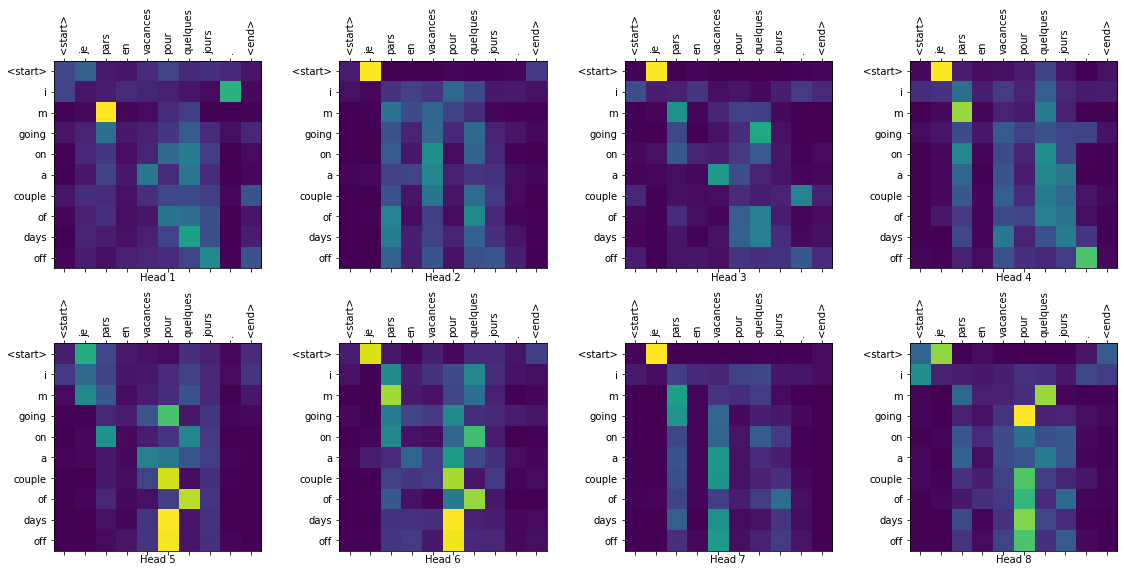

In [60]:
translate(sentence_pairs[0], plot='decoder_layer4_block2')

input: je recherche un assistant .
target: i am looking for an assistant .
attention_weights: dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2', 'decoder_layer2_block1', 'decoder_layer2_block2', 'decoder_layer3_block1', 'decoder_layer3_block2', 'decoder_layer4_block1', 'decoder_layer4_block2'])
pred: <start> i m looking for a lot .



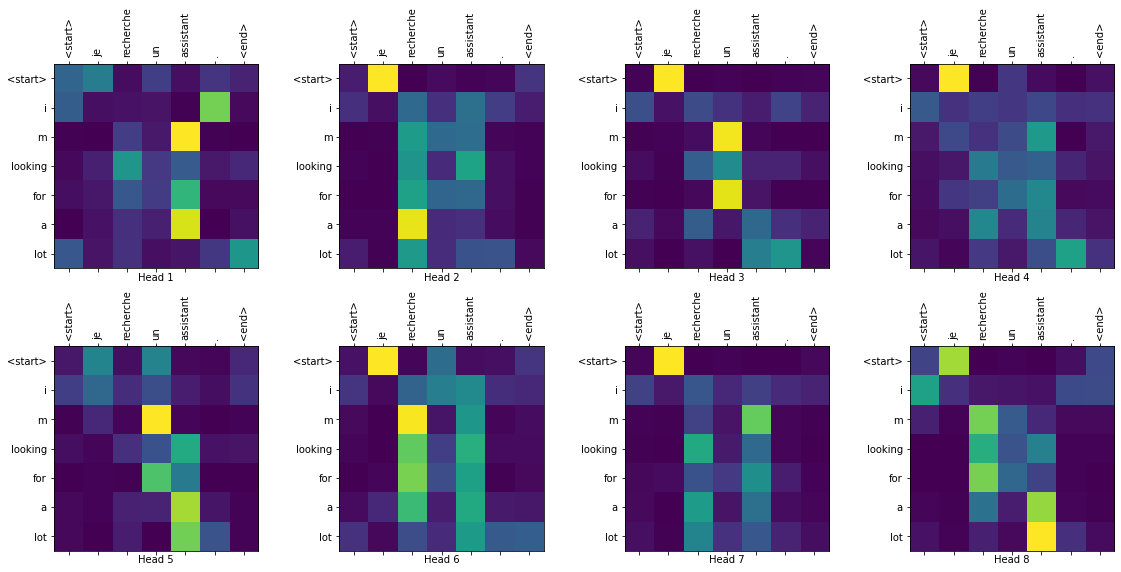

In [61]:
translate(sentence_pairs[2], plot='decoder_layer4_block2')


## 19.总结

代码还有以下待完善的地方：
- 没有实现标签平滑
- 在训练过程中使用了teacher-forcing，即总是会将target传递到下一时间步长。更好的做法是设置一个teacher_forcing_ration
- 在evaluate阶段的解码使用的是greedy search decode，即对于每一步，我们只需从具有最高 softmax 值的 decoder_output 中选择单词。可以尝试使用更好的beam search